In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
import random

In [257]:
size = 100


def generate_points(n, distribution, mu=(size//2, size//2), sigma=(5 * np.identity(2))):
    if distribution == "uniform":
        points = np.random.uniform((0, 0), (size, size), (n, 2))
    elif distribution == "normal":
        points = np.random.multivariate_normal(mu, sigma, n)
    elif distribution == "separated":
        points = np.zeros((n, 2))
        possible_places = [x for x in range(0, 25)]

        for i in range(9):
            place = random.choice(possible_places)
            possible_places.remove(place)
            for k in range((i * n) // 9, ((i+1) * n) // 9):
                curr_mu = ((size / 5) * (place // 5) + size/10, (size / 5) * (place % 5) + size/10)
                points[k] = np.random.multivariate_normal(curr_mu, sigma, 1)
    else:
        points = [[]]

    return points


def dist(a, b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)


def get_cost(points):
    n = points.shape[0]
    cost = 0
    for i in range(n):
        cost += dist(points[i], points[(i + 1) % n])

    return cost


def anneal(points, t_max, multiplier, iterations, second_random=False):
    frames = [points]

    optimal_points = points.copy()
    n = points.shape[0]

    cost = get_cost(points)
    costs = [(0, cost)]

    it = 1
    t = t_max
    while it < iterations:
        point1_to_swap = random.randint(0, n - 1)
        point2_to_swap = random.randint(0, n - 1) if second_random else (point1_to_swap + 1) % n
        if point1_to_swap == point2_to_swap:
            point2_to_swap = (point2_to_swap + 1) % n

        new_permutation = optimal_points.copy()
        new_permutation[[point1_to_swap, point2_to_swap]] = new_permutation[[point2_to_swap, point1_to_swap]]

        new_cost = get_cost(new_permutation)

        if new_cost < cost or math.e ** ((cost - new_cost) / t) > random.random():
            optimal_points = new_permutation
            cost = new_cost
            frames.append(new_permutation)
            costs.append((it, new_cost))

        it += 1
        t *= multiplier
        
    frames.append(optimal_points)
    costs.append((it, cost))

    return optimal_points, frames, costs


def show(points):
    plt.scatter(points[:, 0], points[:, 1], c="#FF0000")
    line = points.copy()
    line = np.append(line, [line[0]], axis=0)
    plt.plot(line[:, 0], line[:, 1])
    plt.show()

<IPython.core.display.Javascript object>


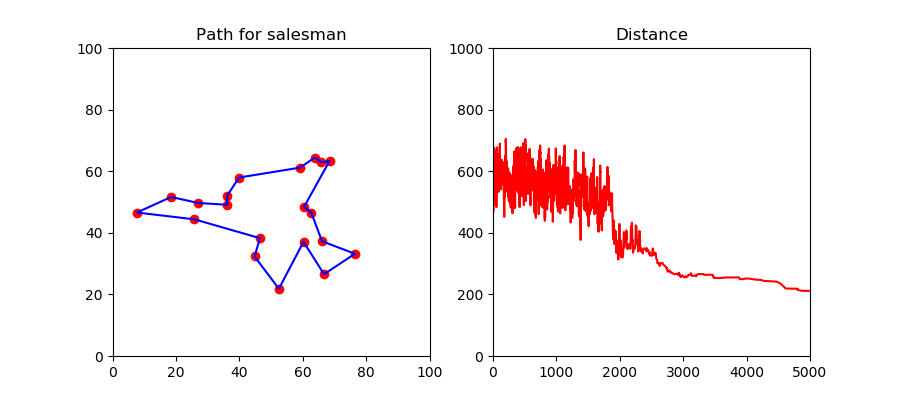

1902


In [267]:
t_max = 1000
multiplier = 0.998
iterations = 5000
arbitrary = True

%matplotlib nbagg

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# points = generate_points(30, "uniform")
points = generate_points(20, "normal", sigma=np.array([[300,0],[0,300]]))
# points = generate_points(20, "separated")
points, frames, costs = anneal(points, t_max, multiplier, iterations, arbitrary)

path, = ax[0].plot([], [], 'b-')
ax[0].scatter(points[:, 0], points[:, 1], c="#FF0000")
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[0].set_title("Path for salesman")

cost_line, = ax[1].plot([], [], 'r-')
ax[1].set_xlim(0, iterations)
ax[1].set_ylim(0, 1000)
ax[1].set_title("Distance")
xcost = []
ycost = []

print(len(costs))
def update_path(i):
    frame = frames[int(i)]
    xdata = frame[:, 0]
    ydata = frame[:, 1]
    
    xdata = np.append(xdata, xdata[0])
    ydata = np.append(ydata, ydata[0])
    
    xcost.append(costs[int(i)][0])
    ycost.append(costs[int(i)][1])
    
    path.set_data(xdata, ydata)
    
    cost_line.set_data(xcost, ycost)
    return path, cost_line

def update_cost(cost):
    xcost.append(cost[0])
    ycost.append(cost[1])
    
    cost_line.set_data(xcost, ycost)
    return cost_line, 


ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()